### 0. Prereqs

In [1]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.feature_selection import (
    SequentialFeatureSelector,
)
from mlxtend.evaluate import feature_importance_permutation
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.utils.estimator_checks import check_estimator
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
import matplotlib.ticker as ticker
import os
from pathlib import Path
import json

import sys

sys.path.append("scripts")

import utils
import distclassipy as dcpy

cd = dcpy.Distance()

In [2]:
with open("settings.txt") as f:
    settings_dict = json.load(f)
np.random.seed(settings_dict["seed_choice"])

classification_letter = "c"
classification_problem = settings_dict["classification_problem"][classification_letter]
classes_to_keep = settings_dict["classes_to_keep"][classification_letter]
results_subfolder = f"{classification_letter}. {classification_problem}"
sns_dict = settings_dict["sns_dict"]

sns.set_theme(**sns_dict)

In [3]:
# Load Data
X_df_FULL = pd.read_csv("data/X_df.csv", index_col=0)
y_df_FULL = pd.read_csv("data/y_df.csv", index_col=0)

In [4]:
# Remove features to be dropped from previous notebook
with open(os.path.join("results", results_subfolder, "drop_features.txt")) as f:
    bad_features = json.load(f)  # manually selected

X_df_FULL = X_df_FULL.drop(bad_features, axis=1)

print(X_df_FULL.shape[1])

31


In [5]:
# Keep only current classes
cl_keep_str = "_".join(classes_to_keep)

y_df = y_df_FULL[y_df_FULL["class"].isin(classes_to_keep)]
X_df = X_df_FULL.loc[y_df.index]
X = X_df.to_numpy()
y = y_df.to_numpy().ravel()

In [6]:
with open(os.path.join("results", results_subfolder, "best_common_features.txt")) as f:
    best_common_features = json.load(f)

In [7]:
all_metrics = [
    "euclidean",
    "braycurtis",
    "canberra",
    "cityblock",
    "chebyshev",
    cd.clark,
    "correlation",
    "cosine",
    cd.hellinger,
    cd.jaccard,
    cd.lorentzian,
    cd.marylandbridge,
    cd.meehl,
    cd.motyka,
    cd.soergel,
    cd.wave_hedges,
    cd.kulczynski,
    cd.add_chisq,
]

---
### TEMP
---


In [8]:
metric = "canberra"

In [9]:
metric_str = utils.get_metric_name(metric)
print("*" * 20, metric_str, "*" * 20)

******************** Canberra ********************


In [10]:
lcdc1 = dcpy.DistanceMetricClassifier(
    metric=metric, scale=True, 
    central_stat=settings_dict["central_stat"], 
    dispersion_stat=settings_dict["dispersion_stat"],
    calculate_kde=False, calculate_1d_dist=False
)

lcdc2 = dcpy.DistanceMetricClassifier(
    metric=metric, scale=True, 
    central_stat=settings_dict["central_stat"], 
    dispersion_stat=settings_dict["dispersion_stat"],
    calculate_kde=False, calculate_1d_dist=False
)


In [11]:
X1, X2, y1, y2 = train_test_split(
        X_df, y_df, test_size=0.5, stratify=y, random_state=settings_dict["seed_choice"]
    )

In [12]:
scoring = "f1_macro"

# Sequential Feature Selection first classifier
feat_selector1 = SequentialFeatureSelector(
    lcdc1,
    k_features=X1.shape[1],
    scoring=scoring,
    forward=True,
    n_jobs=-1,
    verbose=0,
).fit(X1, y1)

# Sequential Feature Selection second classifier
feat_selector2 = SequentialFeatureSelector(
    lcdc2,
    k_features=X2.shape[1],
    scoring=scoring,
    forward=True,
    n_jobs=-1,
    verbose=0,
).fit(X2, y2)


In [13]:
res_df1 = pd.DataFrame.from_dict(feat_selector1.get_metric_dict()).T
res_df1.index.name = "num_feats"
res_df1["avg_score"] = res_df1["avg_score"].astype("float")
res_df1 = res_df1.sort_values(by="avg_score", ascending=False)
res_df1.to_csv(".tempres_df1.csv")

res_df2 = pd.DataFrame.from_dict(feat_selector2.get_metric_dict()).T
res_df2.index.name = "num_feats"
res_df2["avg_score"] = res_df2["avg_score"].astype("float")
res_df2 = res_df2.sort_values(by="avg_score", ascending=False)
res_df2.to_csv(".tempres_df2.csv")

In [14]:
# Reloading to
sfs_df1 = pd.read_csv(".tempres_df1.csv", index_col=0)
feats_idx1, feats1 = utils.load_best_features(sfs_df1)
print(f"{metric_str} LCDC 1: Selected {len(feats1)} features: {feats1}")

sfs_df2 = pd.read_csv(".tempres_df1.csv", index_col=0)
feats_idx2, feats2 = utils.load_best_features(sfs_df2)
print(f"{metric_str} LCDC 2: Selected {len(feats2)} features: {feats2}")

Canberra LCDC 1: Selected 2 features: ['Period_band_r', 'Harmonics_phase_2_r']
Canberra LCDC 2: Selected 2 features: ['Period_band_r', 'Harmonics_phase_2_r']


In [15]:
# results_dict[metric_str][1]["selected_feats"] = feats1
# results_dict[metric_str][2]["selected_feats"] = feats2

# results_dict[metric_str][1]["num_feats"] = len(feats1)
# results_dict[metric_str][2]["num_feats"] = len(feats2)

In [16]:
def custom_plot_sfs(feat_selector, feats, title=""):
    fig = plot_sfs(
        feat_selector.get_metric_dict(),
        kind="std_dev",
        # color=sns.color_palette("Paired")[1],
        # bcolor=sns.color_palette("Paired")[0],
        color=sns.color_palette()[0],
        bcolor="#93aad0",
        ylabel="F1 Score (%)",  # scoring
    )
    fig[1].set_title(title) #Set 1 (first half)

    tick_freq = 5
    fig[1].set_xticks(
        [x for x in list(feat_selector.get_metric_dict().keys()) if x % tick_freq == 0]
    )

    # Temp fix to get % instead of 0-1 values
    fig[1].yaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, pos: "{0:g}".format(x * 100))
    )

    plt.locator_params(axis="y", nbins=6)
    plt.axvline(x=len(feats), color=sns.color_palette()[3], label="Selected features")

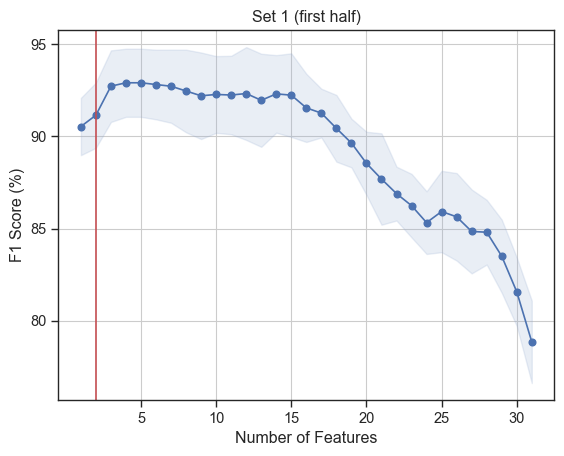

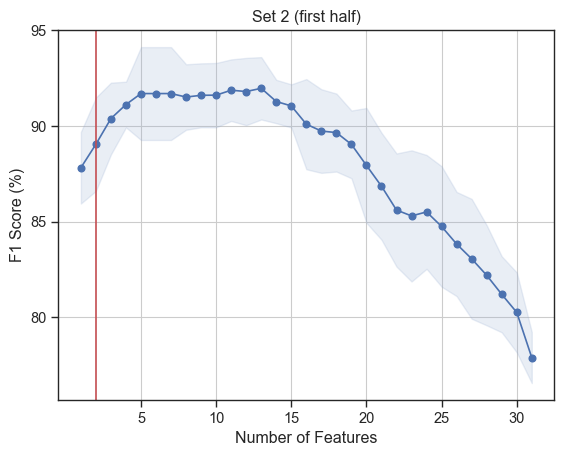

In [17]:
custom_plot_sfs(feat_selector1, feats1,"Set 1 (first half)")

custom_plot_sfs(feat_selector2, feats2,"Set 2 (first half)")

In [18]:
HIDDENy_df = pd.read_csv("data/HIDDENy_df_multiclass.csv", index_col=0)
HIDDENX_df = pd.read_csv("data/HIDDENX_df_multiclass.csv", index_col=0)

In [19]:
HIDDENX_df1 = HIDDENX_df.loc[:, feats1]
HIDDENX_df1 = HIDDENX_df1.dropna()
HIDDENy_df1 = HIDDENy_df.loc[HIDDENX_df1.index]
HIDDENX1 = HIDDENX_df1.to_numpy()
HIDDENy1 = HIDDENy_df1.to_numpy().ravel()

HIDDENX_df2 = HIDDENX_df.loc[:, feats2]
HIDDENX_df2 = HIDDENX_df2.dropna()
HIDDENy_df2 = HIDDENy_df.loc[HIDDENX_df2.index]
HIDDENX2 = HIDDENX_df2.to_numpy()
HIDDENy2 = HIDDENy_df2.to_numpy().ravel()

# assert (HIDDENX2 == HIDDENX2).all()

In [20]:
HIDDENypred1 = lcdc1.predict(HIDDENX1)
HIDDENypred2 = lcdc2.predict(HIDDENX2)

NotFittedError: This DistanceMetricClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:






    results_dict[metric_str] = {}
    choose_objs = 50

    for run_num in tqdm(range(1, 11), desc="Run Number", leave=False):

        print("*" * 10, f"Run {run_num}", "*" * 10)

        #### NEW - choose 100 from each class
        cury_df = HIDDENy_df.groupby("class").sample(n=choose_objs).sample(frac=1) # Last sample for shuffling
        curX_df = HIDDENX_df.loc[cury_df.index]
        curX = curX_df.to_numpy()
        cury = cury_df.to_numpy().ravel()
        assert curX.shape[0]==cury.shape[0]
        
        results_dict[metric_str][run_num] = {}

        cury_pred = lcdc.predict_and_analyse(curX)
        
        acc = accuracy_score(y_true=cury, y_pred=cury_pred)
        f1score = f1_score(y_true=cury, y_pred=cury_pred, average="macro")
        matthew_coef = matthews_corrcoef(y_true=cury, y_pred=cury_pred)


        results_dict[metric_str][run_num]["acc"] = acc
        results_dict[metric_str][run_num]["f1score"] = f1score
        results_dict[metric_str][run_num]["matthew_coef"] = matthew_coef
        results_dict[metric_str][run_num]["features"] = feats
        results_dict[metric_str][run_num]["choose_objs"] = choose_objs

    
        print("\tExpected Score from training:")
        print(
            f"\t\tF1 = {sfs_df.loc[len(feats)]['avg_score']*100:.2f} ± {sfs_df.loc[len(feats)]['std_dev']*100:.2f}%"
        )
        print("\tActual score on hidden set:")
        # print(f"\tAcc = {100*acc:.2f} %")
        print(f"\t\tF1 = {100*f1score:.2f} %")
    
        ax = utils.plot_cm(y_true=cury, y_pred=cury_pred)
        plt.title(f"{metric_str.title()} metric (hidden set)")
        # plt.savefig(os.path.join(locpath, "hidden_cm.pdf"), bbox_inches="tight")
        # plt.savefig(f"hidden_cm/{metric_str}.pdf",bbox_inches = 'tight')
        plt.show()

---
---

In [ ]:
# results_dict = {}
# for metric in tqdm(all_metrics, desc="Metric", leave=True):
#     metric_str = utils.get_metric_name(metric)
#     locpath = os.path.join("results", results_subfolder, "distclassipy", metric_str)
#     print("*" * 20, metric_str, "*" * 20)

#     sfs_df = pd.read_csv(os.path.join(locpath, "sfs_allfeatures.csv"), index_col=0)
#     feats_idx, feats = utils.load_best_features(sfs_df)

#     lcdc1 = dcpy.DistanceMetricClassifier(
#         metric=metric, scale=True, 
#         central_stat=settings_dict["central_stat"], 
#         dispersion_stat=settings_dict["dispersion_stat"],
#         calculate_kde=False, calculate_1d_dist=False
#     )

#     lcdc2 = dcpy.DistanceMetricClassifier(
#         metric=metric, scale=True, 
#         central_stat=settings_dict["central_stat"], 
#         dispersion_stat=settings_dict["dispersion_stat"],
#         calculate_kde=False, calculate_1d_dist=False
#     )

#     X_df = X_df_FULL.loc[y_df.index]

#     X_df = X_df.loc[:, feats]

#     X = X_df.to_numpy()
#     y = y_df.to_numpy().ravel()

#     lcdc.fit(X, y)

#     HIDDENy_df = pd.read_csv("data/HIDDENy_df_multiclass.csv", index_col=0)
#     HIDDENX_df = pd.read_csv("data/HIDDENX_df_multiclass.csv", index_col=0)

#     HIDDENX_df = HIDDENX_df.loc[:, feats]
#     HIDDENX_df = HIDDENX_df.dropna()
#     HIDDENy_df = HIDDENy_df.loc[HIDDENX_df.index]

#     # HIDDENX = HIDDENX_df.to_numpy()
#     # HIDDENy = HIDDENy_df.to_numpy().ravel()

#     results_dict[metric_str] = {}
#     choose_objs = 50

#     for run_num in tqdm(range(1, 11), desc="Run Number", leave=False):

#         print("*" * 10, f"Run {run_num}", "*" * 10)

#         #### NEW - choose 100 from each class
#         cury_df = HIDDENy_df.groupby("class").sample(n=choose_objs).sample(frac=1) # Last sample for shuffling
#         curX_df = HIDDENX_df.loc[cury_df.index]
#         curX = curX_df.to_numpy()
#         cury = cury_df.to_numpy().ravel()
#         assert curX.shape[0]==cury.shape[0]
        
#         results_dict[metric_str][run_num] = {}

#         cury_pred = lcdc.predict_and_analyse(curX)
        
#         acc = accuracy_score(y_true=cury, y_pred=cury_pred)
#         f1score = f1_score(y_true=cury, y_pred=cury_pred, average="macro")
#         matthew_coef = matthews_corrcoef(y_true=cury, y_pred=cury_pred)


#         results_dict[metric_str][run_num]["acc"] = acc
#         results_dict[metric_str][run_num]["f1score"] = f1score
#         results_dict[metric_str][run_num]["matthew_coef"] = matthew_coef
#         results_dict[metric_str][run_num]["features"] = feats
#         results_dict[metric_str][run_num]["choose_objs"] = choose_objs

    
#         print("\tExpected Score from training:")
#         print(
#             f"\t\tF1 = {sfs_df.loc[len(feats)]['avg_score']*100:.2f} ± {sfs_df.loc[len(feats)]['std_dev']*100:.2f}%"
#         )
#         print("\tActual score on hidden set:")
#         # print(f"\tAcc = {100*acc:.2f} %")
#         print(f"\t\tF1 = {100*f1score:.2f} %")
    
#         ax = utils.plot_cm(y_true=cury, y_pred=cury_pred)
#         plt.title(f"{metric_str.title()} metric (hidden set)")
#         # plt.savefig(os.path.join(locpath, "hidden_cm.pdf"), bbox_inches="tight")
#         # plt.savefig(f"hidden_cm/{metric_str}.pdf",bbox_inches = 'tight')
#         plt.show()

In [ ]:
# # Flatten the dictionary
# data = []
# for method, values in results_dict.items():
#     for key, val in values.items():
#         val['metric'] = method
#         val['run'] = key
#         data.append(val)

# # Convert to DataFrame
# df = pd.DataFrame(data)
# df = df.loc[:,['metric', 'run', 'f1score', 'acc', 'features', 'matthew_coef', 'choose_objs']]

In [ ]:
# print("Mean")
# df.drop(["run"],axis=1).groupby("metric").mean(numeric_only=True)

In [ ]:
# print("Mean")
# df.drop(["run"],axis=1).groupby("metric").mean(numeric_only=True)

In [ ]:
# print("Std deviation")
# df.drop(["run"],axis=1).groupby("metric").std(numeric_only=True)

In [ ]:
# df.drop(["run"],axis=1).groupby("metric").describe().loc[:,[
#     ('f1score', 'count'),
#     ('f1score',  'mean'),
#     ('f1score',   'std'),
#     ('choose_objs', 'mean')
    
#     # ('f1score',   'min'),
#     # ('f1score',   '25%'),
#     # ('f1score',   '50%'),
#     # ('f1score',   '75%'),
#     # ('f1score',   'max'),
#     # ('selected_feats', 'count'),
#     # ('selected_feats',  'mean'),
#     # ('selected_feats',   'std'),
#     # ('selected_feats',   'min'),
#     # ('selected_feats',   '25%'),
#     # ('selected_feats',   '50%'),
#     # ('selected_feats',   '75%'),
#     # ('selected_feats',   'max'),

# ]].round(3)